# Complex Gradient Descent

Nowadays, the traditional approach followed to train neural networks consists into defining a loss function and then training the parameters of the model in order to minimize this loss/cost function. And this can be achieved following __gradient descent__ algorithms, able to minimize/maximize almost any (enough regular) real-valued function. <br>
However, when working with complex-valued models, this traditional approach is no more appliable, especially because in $C$ there is no unique total ordering, in the sense that we cannot take two complex numbers $a$ and $b$ and state _"a is bigger than b"_, and expect everybody to agree. It is possible to define such relation, for example comparing the modulues or following the lexicographical ordering (giving priority to the real parts), but this relation would not be unique. <br>
So, if the fundaments of traditional gradient descent are broken, can we still rely on it to train complex-valued models?

### Complex Analysis

In complex analysis, the concept of complex differentiability is quite different wrt to the corresponding definition in $R$. <br>

Let $D$ be and open set in $C$, and $f$ a complex-valued function on $D$. The function $f$ is __holomorphic__ at the point $z_0\in D$ if the limit

$$
\lim_{h\to 0} \frac{f(z_0+h) - f(z_0)}{h} = f'(z_0)
$$

that corresponds to the _derivative_ of $f$, exists and is finite. <br>
Equivalently, $f$ is holomorphic on a domain $D\subseteq C$ if it is for every $z_0\in D$. <br>

It should be emphasized that in the above limit, $h\in C$ is a complex number that may approach 0 from any direction. The concept of differentiability is, in fact, much stronger in $C$ than with functions of real variables: a holomorphic function will actually be infinitely many times complex differentiable, i.e., the existence of the first derivative will guarantee the existence of derivatives of any order. In the real case, instead, derivability does not necessary implies the continuity of the derivative. Furthermore, the slope of $f$ needs to be identical for every trajectory in the complex plane through $z_0$.

Unfortunately, even seemingly simple functions are not holomorphic. The square modulus itself, $f(z)= |z|^2 =z\bar{z}$, for example. <br>
But, under this perspective, how can we provide an efficient and coherent way to optimize any loss function associated to a machine learning problem? How can we exploit gradient descent if most of the times losses and neurons’ activations are non-holomorphic? <br>
A possible alternative exists: just as subgradients enable us to optimize functions that are not differentiable across their domain (e.g. ReLU), we can leverage __Wirtinger calculus__ (or __CR-calculus__) to optimize functions that are not holomorphic but still differentiable with respect to their real and imaginary components. <br>
The core idea behind this approach is basically a "change of basis" for the complex number $z=x+iy$, from the traditional representation as a vector in $R^2$, i.e. $r = (x; y)^T$, to the so called conjugate coordinates:

$$
c\equiv(z,\bar{z})^T \in C\times C \qquad z=x+iy\quad\text{and}\quad \bar{z}=x-iy
$$

Wirtinger operators permit the construction of a differential calculus for complex-valued functions, that is entirely analogous to its ordinary real-valued counterpart. Furthermore, it allow us to avoid the expansion of the input into its real and imaginary components and the successive derivation (that would be just a simple real derivative). Those operators we were talking about are the __R-derivative__, $\partial f/\partial z$ (computed treating $z$ as a real variable and holding instances of $\bar{z}$ constant) and the __conjugate R-derivative__, $\partial f/\partial\bar{z}$ (same but this time treating z like a constant). More formally, we can construct
the following operators:

$$
\frac{\partial}{\partial z}\equiv\partial_z = \frac{1}{2}(\partial_x-i\partial_y) \qquad\qquad \frac{\partial}\partial{\bar{z}}\equiv\partial_{\bar{z}} = \frac{1}{2}(\partial_x+i\partial_y)
$$

In backpropagation we need to compute the derivatives of the final loss function with respect to the parameters of the network across the various layers. The task can be achieved applying the chain rule multiplying the upstream derivatives times the local derivatives for a specific layer function. For this reason it may be useful to write down also the _chain rule_ for the CR-derivatives, even if, in the end, it is just and extension of the real case:

$$
\frac{\partial(f\cdot g)}{\partial z}=\frac{\partial f}{\partial g}\frac{\partial g}{\partial z} + \frac{\partial f}{\partial\bar{g}}\left(\frac{\partial g}{\partial\bar{z}}\right)^* \qquad\qquad \frac{\partial(f\cdot g)}{\partial\bar{z}}=\frac{\partial f}{\partial g}\frac{\partial g}{\partial\bar{z}} + \frac{\partial f}{\partial\bar{g}}\left(\frac{\partial g}{\partial z}\right)^*
$$

where $g$ is a complex-valued function of $z$. <br>
Rearranging the previous functions, one can derive also the following identities:

$$
\frac{\partial\bar{f}}{\partial\bar{z}} = \left({\frac{\partial f}{\partial z}}\right)^* \qquad\qquad \frac{\partial\bar{f}}{\partial z} = \left({\frac{\partial f}{\partial \bar{z}}}\right)^*
$$

Furthermore, in the case of a real-valued output, with $f(z):C\to R$, there is an additional pair of identities that hold:

$$
\frac{\partial f}{\partial z} = \left({\frac{\partial f}{\partial \bar{z}}}\right)^* \qquad\qquad \frac{\partial f}{\partial\bar{z}} = \left({\frac{\partial f}{\partial z}}\right)^*
$$

Back to our problem of optimizing a real-valued loss function (a strong but valid assumption since minimizing a complex-valued function is an ambiguous operation), we need to define a working backpropagation algorithm. <br>
Let’s then consider a function $f(z):C\to R$: if we decide to proceed with a gradient descent algorithm, which direction are we supposed to take since there are two different derivatives that one can compute ($\partial/\partial z$ and $\partial/\partial\bar{z}$)? <br>
It can be proved, that the direction of the __steepest gradient descent__ is the __complex cogradient__, $\nabla_{\bar{z}}f$. So, given a function $f$ that depends on a complex random variable $z\in C$, the update rule that minimizes it is:

$$
z \leftarrow z - \alpha\nabla_{\bar{z}}f
$$

where $\alpha$ is the learning rate.

Analytical proofs of the steepes gradient descent rule can be found at:

* _H. Li and T. Adali, \Complex-valued adaptive signal processing using nonlinear functions," EURASIP J. Adv. Sig. Proc., vol. 2008, 12 2008_
* _F. Amin, M. Amin, A. Y. H. Al Nuaimi, and K. Murase, \Wirtinger calculus based gradient descent and levenberg-marquardt learning algorithms in complex-valued neural networks," vol. 7062, pp. 550{559, 11 2011._

### Implementation of the complex gradient descent algorithm

Given all the previous theoretical introduction, now we have to prove, also from a practical point of view, the gradient descent rule stated above.

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import jax.numpy as jnp
from jax import jit, grad, vmap
%matplotlib inline

Let's briefly implement a small gradient descent algorithm, following the approach suggested by `JAX` to handle the complex derivatives.

In [2]:
def gd(func, init, n_epochs=100, lr=1e-4, conj=True, maximize=False):
    params = np.array(init)
    params_traj = np.zeros([n_epochs+1,1], dtype=np.cfloat)
    params_traj[0] = init
    val_func = np.zeros([n_epochs + 1], dtype=np.cfloat)
    val_func[0] = func(*params)
    v = 0

    for j in range(n_epochs):
        v = lr*grad(func)(params[0])
        if conj:
            v = np.conj(v)
        if maximize:
            params = params + v
        else:
            params = params - v
        params_traj[j+1,] = params
        val_func[j+1] = func(*params)
    
    return params_traj.flatten(), val_func.flatten()

Take a real-valued function with complex input with a unique global minimum that is easy to identify, for simplicity. Our choice fell on the square-modulus function, that has a minimum at $z=0.+i0.$.

In [3]:
@jit
def f(z):
    square_mod = z * jnp.conj(z)
    return square_mod.real

Finally, let's give a clear visualization of the results.

In [4]:
# Function data plot
x = np.linspace(-5, 5)
y = np.linspace(-5, 5)
z_values = x + 1.j*y

xx, yy = np.meshgrid(x, y)
z = f(xx + 1.j*yy)

Text(0, 0.5, 'Imaginary Part')

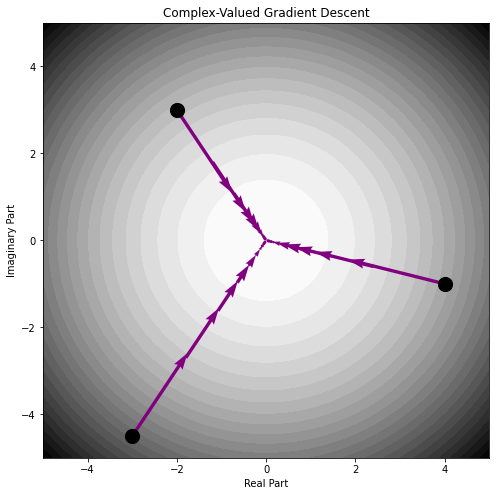

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

ax.contourf(x, y, z, 30, cmap='binary')

# Set the initial points of the gradient descents
init_points = np.array([4.-1.j, -3.-4.5j, -2.+3.j])
for p in init_points:
    pts_gd, _ = gd(func=f, init=[p], n_epochs=10, lr=2e-1, conj=True, maximize=False)
    
    # Setup the arrow plot
    xp = pts_gd.real
    yp = pts_gd.imag
    ax.quiver(xp[:-1], yp[:-1], np.diff(xp), np.diff(yp), color='purple')

    
# Mark the initial points
ax.scatter(init_points.real, init_points.imag, s=200, marker='o', c='black')

ax.set_title('Complex-Valued Gradient Descent')
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')

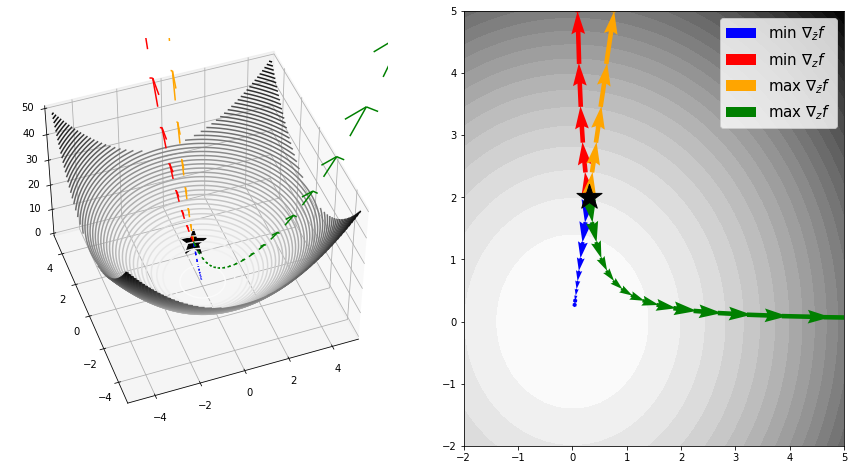

In [6]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)

ax1.contour3D(x, y, z, 50, cmap='binary')
ax2.contourf(x, y, z, 30, cmap='binary')

init_point = [0.3+2.j]

pts_traj_conj, fn_traj_conj = gd(func=f, init=init_point, n_epochs=10, lr=1e-1, conj=True, maximize=False)
pts_traj, fn_traj = gd(func=f, init=init_point, n_epochs=10, lr=1e-1, conj=False, maximize=False)

pts_traj_conj_max, fn_traj_conj_max = gd(func=f, init=init_point, n_epochs=10, lr=1e-1, conj=True, maximize=True)
pts_traj_max, fn_traj_max = gd(func=f, init=init_point, n_epochs=30, lr=1e-1, conj=False, maximize=True)

traj_pts = [pts_traj_conj, pts_traj, pts_traj_conj_max, pts_traj_max]
traj_fn = [fn_traj_conj, fn_traj, fn_traj_conj_max, fn_traj_max]
colors = ['blue', 'red', 'orange', 'green']
labels = [r'min $\nabla_{\bar{z}}f$', r'min $\nabla_{z}f$', r'max $\nabla_{\bar{z}}f$', r'max $\nabla_{z}f$']

for i in range(4):
    xp = traj_pts[i].real
    yp = traj_pts[i].imag
    zp = traj_fn[i].real
    
    ax2.quiver(xp[:-1], yp[:-1], np.diff(xp), np.diff(yp), color=colors[i], scale=6., width=0.012, label=labels[i])
    
    ax1.quiver(xp[:-1], yp[:-1], zp[:-1], np.diff(xp), np.diff(yp), np.diff(zp), 
               color=colors[i], label=labels[i], length=.5)

ax1.scatter(0.3, 2, f(*init_point), s=700, color='black', marker='*')
ax2.scatter(0.3, 2, s=700, color='black', marker='*')

ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_zlim(0,50)
ax1.view_init(45, 250)
#ax1.legend(fontsize=15);

ax2.set_xlim(-2,5)
ax2.set_ylim(-2,5)
ax2.legend(fontsize=15);

Using $\frac{\partial f}{\partial z}$ rather than $\frac{\partial f}{\partial \bar{z}}$ the function is maximized and not minimized. And since JAX, by default, calculate the first derivative, we need to rememeber that we have to take the complex conjugate before updating the parameters.

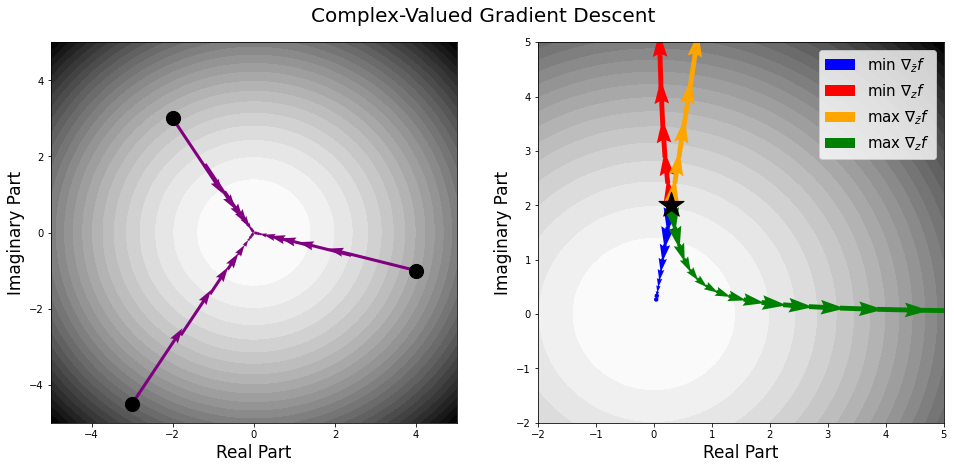

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16,7))

axs[0].contourf(x, y, z, 30, cmap='binary')

# Set the initial points of the gradient descents
init_points = np.array([4.-1.j, -3.-4.5j, -2.+3.j])
for p in init_points:
    pts_gd, _ = gd(func=f, init=[p], n_epochs=10, lr=2e-1, conj=True, maximize=False)
    
    # Setup the arrow plot
    xp = pts_gd.real
    yp = pts_gd.imag
    axs[0].quiver(xp[:-1], yp[:-1], np.diff(xp), np.diff(yp), color='purple')

    
# Mark the initial points
axs[0].scatter(init_points.real, init_points.imag, s=200, marker='o', c='black')


axs[1].contourf(x, y, z, 30, cmap='binary')

init_point = [0.3+2.j]

pts_traj_conj, fn_traj_conj = gd(func=f, init=init_point, n_epochs=10, lr=1e-1, conj=True, maximize=False)
pts_traj, fn_traj = gd(func=f, init=init_point, n_epochs=10, lr=1e-1, conj=False, maximize=False)

pts_traj_conj_max, fn_traj_conj_max = gd(func=f, init=init_point, n_epochs=10, lr=1e-1, conj=True, maximize=True)
pts_traj_max, fn_traj_max = gd(func=f, init=init_point, n_epochs=30, lr=1e-1, conj=False, maximize=True)

traj_pts = [pts_traj_conj, pts_traj, pts_traj_conj_max, pts_traj_max]
traj_fn = [fn_traj_conj, fn_traj, fn_traj_conj_max, fn_traj_max]
colors = ['blue', 'red', 'orange', 'green']
labels = [r'min $\nabla_{\bar{z}}f$', r'min $\nabla_{z}f$', r'max $\nabla_{\bar{z}}f$', r'max $\nabla_{z}f$']

for i in range(4):
    xp = traj_pts[i].real
    yp = traj_pts[i].imag
    zp = traj_fn[i].real
    
    axs[1].quiver(xp[:-1], yp[:-1], np.diff(xp), np.diff(yp), color=colors[i], scale=6., width=0.012, label=labels[i])
    
axs[1].scatter(0.3, 2, s=700, color='black', marker='*')


fig.suptitle('Complex-Valued Gradient Descent', fontsize=20, y=0.95)
axs[0].set_xlabel('Real Part', fontsize=17)
axs[0].set_ylabel('Imaginary Part', fontsize=17)

axs[1].set_xlabel('Real Part', fontsize=17)
axs[1].set_ylabel('Imaginary Part', fontsize=17)
axs[1].set_xlim(-2,5)
axs[1].set_ylim(-2,5)
axs[1].legend(fontsize=15);

In [8]:
#fig.savefig('cmplx_gradient_descent.pdf', tight_layout=True)